In [1]:
from helpers.helper_functions import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import networkx as nx
import matplotlib
import random

import findspark
findspark.init()
from pyspark import SparkContext
from pyspark.sql import *
from pyspark.sql.functions import unix_timestamp
from pyspark.sql.types import StringType

# initialize spark context
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext


# The Significant Bang Theory

Attention, ADA students!

The Sheldon Cooper we all know and love (OK, some of us might not know him, and some might not love him) from the TV series "The Big Bang Theory" has gotten into an argument with Leonard from the same TV show. Sheldon insists that he knows the show better than anyone, and keeps making various claims about the show, which neither of them know how to prove or disprove. The two of them have reached out to you ladies and gentlemen, as data scientists, to help them. You will be given the full script of the series, with information on the episode, the scene, the person saying each dialogue line, and the dialogue lines themselves.

Leonard has challenged several of Sheldon's claims about the show, and throughout this exam you will see some of those and you will get to prove or disprove them, but remember: sometimes, we can neither prove a claim, nor disprove it!

## Deadline
Wednesday, January 30th, 2019; 11:15 A.M. (Swiss time)

_For the deadline for extramural exams, see the submission subsection._

## Important notes
* Don't forget to add a textual description of your thought process, the assumptions you made, and your results!
* Please write all your comments in English, and use meaningful variable names in your code.
* As we have seen during the semester, data science is all about multiple iterations on the same dataset. Do not obsess over small details in the beginning, and try to complete as many tasks as possible during the first 2 hours. Then, go back to the obtained results, write meaningful comments, and debug your code if you have found any glaring mistake.
* Fully read the instructions for each question before starting to solve it to avoid misunderstandings, and remember to save your notebook often!
* The exam contains **15 questions organised into 4 tasks**, and is designed for more than 3 hours. **You do not need to solve everything in order to get a 6**, and you have some freedom is choosing the tasks you wish to solve.
* You cannot leave the room in the first and last 15 minutes.
* You can use all the online resources you want except for communication tools (emails, web chats, forums, phone, etc.). We will be monitoring the network for unusual activity.
* Remember, this is not a homework assignment -- no teamwork allowed!

## Submission
* Your file has to be named as "NameSurname_SCIPER.ipynb".
* Make sure you upload your Jupyter Notebook (1 file) to [this](https://goo.gl/forms/7GLvYl94uSOn54jH2) Google form at the end of the exam, with all the cells already evaluated (except for the Spark-related question, Q7). You need to sign in to Google using your EPFL credentials in order to submit the form.
* In case of problems with the form, send your Jupyter Notebook (along with your name and SCIPER number) as a direct message to @ramtin on Mattermost. This is reserved only for those who encounter problems with the submission -- you need to have a reasonable justification for using this back-up.
* You will have until 11:20 (strict deadline) to turn in your submission. **Late submissions will not be accepted.** This deadline is for the students taking the exam at EPFL -- students taking the exam extramurally will have their submission deadline as the starting time of the exam plus 3 hours and 5 minutes.

## Task A: Picking up the shovel (10 points)

**Note: You will use the data you preprocess in this task in all the subsequent ones.**

Our friends' argument concerns the entire show. We have given you a file in the `data/` folder that contains the script of every single episode. New episodes are indicated by '>>', new scenes by '>', and the rest of the lines are dialogue lines. Some lines are said by multiple people (for example, lines indicated by 'All' or 'Together'); **you must discard these lines**, for the sake of simplicity. However, you do not need to do it for Q1 in this task -- you'll take care of it when you solve Q2.

**Q1**. (5 points) Your first task is to extract all lines of dialogue in each scene and episode, creating a dataframe where each row has the episode and scene where a dialogue line was said, the character who said it, and the line itself. You do not need to extract the proper name of the episode (e.g. episode 1 can appear as "Series 01 Episode 01 - Pilot Episode", and doesn't need to appear as "Pilot Episode"). Then, answer the following question: In total, how many scenes are there in each season? We're not asking about unique scenes; the same location appearing in two episodes counts as two scenes. You can use a Pandas dataframe with a season column and a scene count column as the response.

**Note: The data refers to seasons as "series".**

In [2]:
array = []
episode = None
scene = None

with open("data/all_scripts.txt", "r") as file:
    for line in file:
        if line.startswith(">>"):
            episode = line[10:]
        elif line.startswith(">"):
            scene = line[2:]
        else:
            parts = line.split(": ")
            character = parts[0]
            dialogue = line.replace(character + ": ", "")
            
            array.append([episode, scene, character, dialogue])

In [3]:
df = pd.DataFrame(array, columns=["episode", "scene", "character", "dialogue"] )

In [4]:
df.head()

,episode,scene,character,dialogue
0,01 Episode 01 – Pilot Episode\n,A corridor at a sperm bank.\n,Sheldon,So if a photon is directed through a plane wit...
1,01 Episode 01 – Pilot Episode\n,A corridor at a sperm bank.\n,Leonard,"Agreed, what’s your point?\n"
2,01 Episode 01 – Pilot Episode\n,A corridor at a sperm bank.\n,Sheldon,"There’s no point, I just think it’s a good ide..."
3,01 Episode 01 – Pilot Episode\n,A corridor at a sperm bank.\n,Leonard,Excuse me?\n
4,01 Episode 01 – Pilot Episode\n,A corridor at a sperm bank.\n,Receptionist,Hang on.\n


In [5]:
df["season"] = df["episode"].apply(lambda x: x.split(" ")[0])

In [6]:
df.groupby("season").scene.nunique()

season
01    139
02    159
03    124
04    131
05    134
06    127
07    114
08    107
09     89
10     90
Name: scene, dtype: int64

**Comment:** The unique scenes are obtained by simple groupby operation and counting of the unique scenes.

**Q2**. (5 points) Now, let's define two sets of characters: all the characters, and recurrent characters. Recurrent characters are those who appear in more than one episode. For the subsequent sections, you will need to have a list of recurrent characters. Assume that there are no two _named characters_ (i.e. characters who have actual names and aren't referred to generically as "little girl", "grumpy grandpa", etc.) with the same name, i.e. there are no two Sheldons, etc. Generate a list of recurrent characters who have more than 90 dialogue lines in total, and then take a look at the list you have. If you've done this correctly, you should have a list of 20 names. However, one of these is clearly not a recurrent character. Manually remove that one, and print out your list of recurrent characters. To remove that character, pay attention to the _named character_ assumption we gave you earlier on. **For all the subsequent questions, you must only keep the dialogue lines said by the recurrent characters in your list.**

_Hint: "I know all the recurrent characters because I've watched the entire series five times" is not an acceptable argument, so you need to actually generate the list._

In [8]:
df.head()

,episode,scene,character,dialogue,season
0,01 Episode 01 – Pilot Episode\n,A corridor at a sperm bank.\n,Sheldon,So if a photon is directed through a plane wit...,01
1,01 Episode 01 – Pilot Episode\n,A corridor at a sperm bank.\n,Leonard,"Agreed, what’s your point?\n",01
2,01 Episode 01 – Pilot Episode\n,A corridor at a sperm bank.\n,Sheldon,"There’s no point, I just think it’s a good ide...",01
3,01 Episode 01 – Pilot Episode\n,A corridor at a sperm bank.\n,Leonard,Excuse me?\n,01
4,01 Episode 01 – Pilot Episode\n,A corridor at a sperm bank.\n,Receptionist,Hang on.\n,01


In [9]:
char_ep = df.groupby(["character"]).episode.nunique()

In [10]:
char_ep = char_ep[char_ep > 1]

In [11]:
df_new = df[df["character"].isin(char_ep.index)]

**Comment:** First I filter the characters that have occured in less than one episode. And save them in the df_new dataframe.

In [12]:
more_90_lines = df_new.groupby("character").count()

In [13]:
more_90_lines = more_90_lines[more_90_lines["episode"] > 90]

In [14]:
recurrent_character = list(more_90_lines.index)

**Comment:** After that I filter the characters with less than 90 dialogue lines. I got 20 characters which means the filtering is done properly, and after obeserving the list there is a character named "Man" violating the name charcater assumption. I remove him from the list.

In [15]:
recurrent_character.remove("Man")

In [16]:
len(recurrent_character)

19

In [17]:
recurrent_character

['Amy',
 'Arthur',
 'Bernadette',
 'Bert',
 'Beverley',
 'Emily',
 'Howard',
 'Kripke',
 'Leonard',
 'Leslie',
 'Mrs Cooper',
 'Mrs Wolowitz',
 'Penny',
 'Priya',
 'Raj',
 'Sheldon',
 'Stuart',
 'Wil',
 'Zack']

In [18]:
df_new = df[df["character"].isin(recurrent_character)]

**Comment:** This dataframe consinsts of dialogue lines only from recurrent_characters and I will use it for the rest of the exam.

## Task B: Read the ~~stats~~ scripts carefully (30 points)

### Part 1: Don't put the shovel down just yet

**Q3**. (2.5 points) From each dialogue line, replace punctuation marks (listed in the EXCLUDE_CHARS variable provided in `helpers/helper_functions.py`) with whitespaces, and lowercase all the text. **Do not remove any stopwords, leave them be for all the questions in this task.**

In [19]:
def tmp_replace(string):
    for c in EXCLUDE_CHARS:
        string = string.replace(c, " ")
    return string.lower()

In [20]:
df_new["dialogue"] = df_new["dialogue"].apply(tmp_replace)

/home/blagojce/.conda/envs/ada_epfl/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


**Comment:** This task is simple, only removing the EXCLUDE_CHARS.

**Q4**. (5 points) For each term, calculate its "corpus frequency", i.e. its number of occurrences in the entire series. Visualize the distribution of corpus frequency using a histogram. Explain your observations. What are the appropriate x and y scales for this plot?

In [21]:
corpus_frequency = {}

for dialogue in df_new["dialogue"]:
    for term in dialogue.split(" "):
        if term not in corpus_frequency:
            corpus_frequency[term] = 1
        else:
            corpus_frequency[term] += 1

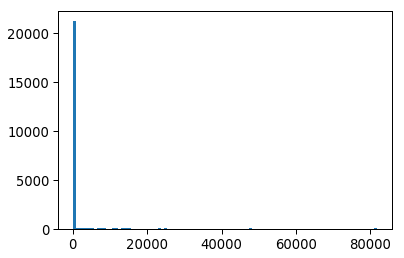

In [224]:
plt.hist(list(corpus_frequency.values()), bins=100)
plt.show()

**Comment:** Looking at the plot like this we can see that some words occur much more than others. This is expected because the word distribution follow a power low called zipf's law.

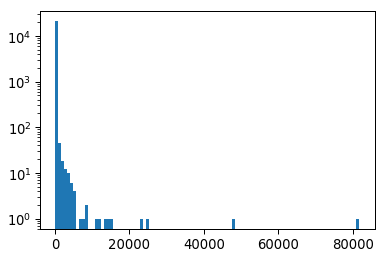

In [239]:
plt.hist(list(corpus_frequency.values()), bins=100, log=True)
plt.show()

**Comment:** If we set the log to True, we will scale the histogram axis and we transform the plot to more informative plot. We still can see that some words appear much more than other words. This clearly looks like a power law.

### Part 2: Talkativity
**Q5**. (2.5 points) For each of the recurrent characters, calculate their total number of words uttered across all episodes. Based on this, who seems to be the most talkative character?

In [40]:
df_new["no_words"] = df_new["dialogue"].apply(lambda x: len(x.split(" ")))

/home/blagojce/.conda/envs/ada_epfl/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [43]:
total_words_per_character = df_new.groupby("character").sum()

In [47]:
total_words_per_character.sort_values("no_words", ascending=False)

,no_words
character,
Sheldon,223272
Leonard,126078
Penny,99517
Howard,84388
Raj,73039
Amy,47997
Bernadette,33510
Stuart,9773
Mrs Cooper,4060


In [250]:
df_new.groupby("character").episode.nunique()

character
Amy             154
Arthur            4
Bernadette      161
Bert              6
Beverley          5
Emily            17
Howard          231
Kripke            8
Leonard         231
Leslie            7
Mrs Cooper        8
Mrs Wolowitz     27
Penny           229
Priya            12
Raj             230
Sheldon         231
Stuart           60
Wil              12
Zack              8
Name: episode, dtype: int64

**Comment:** Based on this observation, Sheldon seems like most talkative pearson. But, because Sheldon is the main character in the series (he appears in all the episodes as we can see from the above table), we should be careful not to jump to conclusions. The fact that he appears in all episodes, means that he probably gets more screen time and hence the high number of words he has said.

**Q6**. (12.5 points) For each of the recurrent characters, calculate their total number of words uttered per episode (ignoring episodes that the character does not appear in), and calculate a **robust summary statistic** for the word count distribution of each person.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**i)** (2.5 points) What changes do you observe, compared to the analysis in Q5?

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**ii)** (2.5 points) Why is this analysis an improvement over the previous one, and how could you improve it even further? _Hint: The improvement involves making your unit for word counts even more granular - you can go further down than episodes._

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**iii)** (7.5 points) Incorporate that improvement. Do you still see the same results? How **confident** can you be that the "most talkative" person given by this twice improved method is really more talkative than the second most talkative one? _Hint: Read the question again. A good idea would be to use bootstrapping and calculate your summary statistic on each bootstrapped set._

In [102]:
words_per_episode = df_new.groupby(["character", "episode"]).sum()

In [103]:
tmp  = words_per_episode.reset_index()

In [104]:
tmp.groupby(["character"]).mean().sort_values("no_words", ascending=False)

,no_words
character,
Sheldon,966.545455
Leonard,545.792208
Mrs Cooper,507.500000
Beverley,489.400000
Arthur,483.250000
Penny,434.572052
Howard,365.316017
Raj,317.560870
Amy,311.668831


In [105]:
tmp.groupby(["character"]).median().sort_values("no_words", ascending=False)

,no_words
character,
Sheldon,936.0
Leonard,486.0
Arthur,437.5
Penny,407.0
Mrs Cooper,356.5
Howard,352.0
Amy,278.0
Raj,267.5
Bert,245.5


**Comment:** If we look at the mean and the median, we could see that the median is smaller for all the characters, and that means there are outlisers in the data. I will use the median, because is more robust to outliers. We have changes in the ordering of the characters, but the top two are the same. This is an improvement because we granulated the observartion, but still the main characters in a episode get more screen time than the supproting characters, and if we still can't make a conclusion now that Sheldon is more talkative.

In [106]:
df_new.groupby(["character"]).mean().sort_values("no_words", ascending=False)

,no_words
character,
Sheldon,19.101035
Mrs Cooper,19.061033
Wil,16.047619
Raj,15.283323
Beverley,15.104938
Arthur,14.869231
Bert,14.810526
Kripke,14.509434
Howard,14.371253


In [107]:
df_new.groupby(["character"]).median().sort_values("no_words", ascending=False)

,no_words
character,
Bert,15.0
Sheldon,15.0
Mrs Cooper,14.0
Beverley,13.0
Kripke,13.0
Raj,12.0
Wil,11.5
Arthur,11.5
Amy,11.0


**Comment:** Now I go even more down, and consider the number of words each pearsons says in a dialog, ininterupted. Now we ave a shift in the rankings, Sheldon is in tie with Bert.

In [ ]:
# bootstraping

In [110]:
sheldon = []
for i in range(1000):
    tmp_new_df = df_new[df_new["character"] == "Sheldon"].sample(frac=1,replace=True)
    sheldon.append(tmp_new_df['no_words'].median())
    
sheldon = np.array(sheldon)

In [111]:
bert = []
for i in range(1000):
    tmp_new_df = df_new[df_new["character"] == "Bert"].sample(frac=1,replace=True)
    bert.append(tmp_new_df['no_words'].median())
    
bert = np.array(bert)

In [112]:
medians = pd.DataFrame({'Sheldon': sheldon,'Bert':bert})

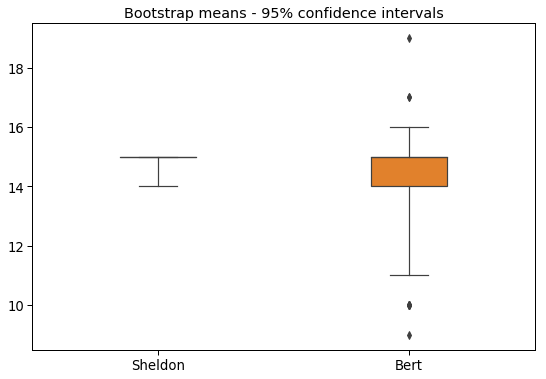

In [120]:
fig = plt.figure(figsize=(9, 6))
fig = sns.boxplot(x=medians.columns, y=[medians['Sheldon'],medians['Bert']], whis=[2.5, 97.5], width=0.3)
plt.title('Bootstrap means - 95% confidence intervals')
fig.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.show()

**Comment:** From the bootstraping we see that Sheldon is consistent with the number of words he says per replay in a dialog, and Bert has a higher variance than Sheldon. There mean value is close and we can't say which character is more talkative, if we consider that talkative means saying more words per reply in a dialog.

### Part 3: Obligatory Spark cameo
**Q7**. (7.5 points) Write a Spark script that does the following: Given the raw input file and your list of recurrent characters, create an RDD containing (speaker, dialogue line) rows **only for the recurrent characters** (assume that you already have the list --  no need to calculate it using Spark), and then generate a vectorized bag of words representation for each dialogue line, thus generating an RDD with (speaker, bag of words vector) rows. Then, calculate an aggregated bag of words vector (sum of all vectors) for each person. The final output is therefore an RDD with each of its rows being (speaker, aggregated bag of words vector). For your bag of words vectors, you can use $1\times|V|$ scipy CSR matrices (where $|V|$ is the size of the vocabulary). No filtering of the vocabulary is necessary for this part.

You do not need to run this script, but you do need to use Spark logic and also, the syntax needs to be correct.

In [180]:
rdd = sc.textFile("data/all_scripts.txt")
rc = sc.broadcast(recurrent_character)

In [181]:
def map_name_line(string):
    name = string.split(": ")[0]
    return (name, string.replace(name + ": ", ""))

In [216]:
rdd_new = rdd.filter(lambda x: not x.startswith(">")) \
         .filter(lambda x: x.split(": ")[0] in rc.value) \
         .map(map_name_line)

**Comment:** First I read the dialogues, filter some of the lines which are not useful for this task. Than I filter only the recurrent characters and create RDD consisting of pairs of (Character, Dialogue).

In [197]:
word_rep = rdd.filter(lambda x: not x.startswith(">")) \
         .filter(lambda x: x.split(": ")[0] in rc.value) \
         .map(map_name_line) \
         .map(lambda x: x[1]) \
         .flatMap(lambda x: x.split(" ")) \
         .distinct()

In [204]:
dist_words = word_rep.collect()

**Comment:** Than I find all the distinct words that the reccurent characters said.

In [217]:
# also use dist_words as broadcast variable, but no time for it now
def transform_to_vector(row):
    sentence_words = row[1].split(" ")
    bag = np.zeros(len(dist_words))
    
    for sw in sentence_words:
        for i, word in enumerate(dist_words):
            if word == sw: 
                bag[i] += 1
        
    return (row[0], np.array(bag))

In [218]:
rdd_new = rdd_new.map(lambda x: transform_to_vector(x))

In [219]:
rdd_new.take(5)

[('Sheldon', array([1., 2., 1., ..., 0., 0., 0.])),
 ('Leonard', array([0., 0., 0., ..., 0., 0., 0.])),
 ('Sheldon', array([0., 0., 0., ..., 0., 0., 0.])),
 ('Leonard', array([0., 0., 0., ..., 0., 0., 0.])),
 ('Leonard', array([0., 3., 0., ..., 0., 0., 0.]))]

**Comment:** After this, using the tranform_to_vector function I transform every row of the RDD to (Character, Bag Of Words).

## Task C: The Gossip Graph (30 points)

**Note: Only for this task, discard the recurrent characters whose names are not single words, e.g. Mrs. Cooper.**

Let us define _gossip_ as follows: if a dialogue line of character A mentions B by name in a scene that does not involve character B, we say that “A gossips about B” in that line. Multiple mentions of the same person in a single line are counted once, but a character can gossip about several others in the same line. For the sake of simplicity, we only consider gossips where the name of the recurrent character is mentioned as it appears in our list of characters; for example, if someone says "Cooper" and they mean Sheldon, we discard that.

**Q8**. (12.5 points) Create the two following graphs first:

1. (5 points) Create the _familiarity graph_, an undirected weighted graph, in which there is a node for each recurrent character, and an edge between two characters if they appear together in at least one scene. The weight of the edge between them is the number of scenes they appear in together. If an edge exists between two people in the familiarity graph, we say that they "know each other".
2. (7.5 points) Create the _gossip graph_, which is a directed weighted graph, in which there there is a node for each recurrent character, and a directed edge from the node for A to the node for B if A has gossiped about B at least once. The weight of the edge is the number of scenes in which A has gossiped about B.

_Hint: You can create each graph first as an adjacency matrix and then create a networkx graph out of that._

Now, answer the following questions:

**Q9**. (5 points) Sheldon claims that every character in the show is familiar with everyone else through at most one intermediary. Based on the familiarity graph, is this true? If not, at most how many intermediaries are needed?

**Q10**. (5 points) Who is the character through whom the largest number of these indirect familiarities happen? Calculate an appropriate centrality metric on the familiarity graph to answer this question. You can use the package networkx for this section.

**Q11**. (2.5 points) Another claim of Sheldon's is that every recurrent character in the show gossips about all the other recurrent characters. What property of the gossip graph would correspond to this? Does the gossip graph possess that property? If not, then is it the case that for every pair of recurrent characters, at least one gossips about the other? What property would this correspond to?

**Q12**. (5 points) Use the gossip graph and the familiarity graph to figure out if for every pair of recurrent characters, one of them has gossiped about the other if and only if they know each other. Explain your method - the simpler, the better.

## Task D: The Detective's Hat (30 points)

Sheldon claims that given a dialogue line, he can, with an accuracy of above 70%, say whether it's by himself or by someone else. Leonard contests this claim, since he believes that this claimed accuracy is too high. Leonard also suspects that it's easier for Sheldon to distinguish the lines that _aren't_ his, rather than those that _are_. We want you to put on the (proverbial) detective's hat and to investigate this claim.

**Q13**. (7.5 points) Divide the set of all dialogue lines into two subsets: the training set, consisting of all the seasons except the last two, and the test set, consisting of the last two seasons. Each of your data points (which is one row of your matrix) is one **dialogue line**. Now, use the scikit-learn class **TfIdfVectorizer** to create TF-IDF representations for the data points in your training and test sets. Note that since you're going to train a machine learning model, everything used in the training needs to be independent of the test set. As a preprocessing step, remove stopwords and words that appear only once from your vocabulary. Use the simple tokenizer provided in `helpers/helper_functions.py` as an input to the TfidfVectorizer class, and use the words provided in `helpers/stopwords.txt` as your stopwords.

In [259]:
df_new["season"] = df_new["season"].astype(int)

/home/blagojce/.conda/envs/ada_epfl/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [289]:
df_train = df_new[np.logical_and((df_new["season"] != 9).values, (df_new["season"] != 10).values)]

In [290]:
df_test = df_new[np.logical_not(np.logical_and((df_new["season"] != 9).values, (df_new["season"] != 10).values))]

In [299]:
stop_words = np.genfromtxt("helpers/stopwords.txt", dtype=str)

In [300]:
stop_words

array(['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you',
       'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his',
       'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself',
       'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which',
       'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are',
       'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had',
       'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and',
       'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at',
       'by', 'for', 'with', 'about', 'against', 'between', 'into',
       'through', 'during', 'before', 'after', 'above', 'below', 'to',
       'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under',
       'again', 'further', 'then', 'once', 'here', 'there', 'when',
       'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
       'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 

In [314]:
def remove_stop_words(string):
    for s in stop_words:
        string = string.replace(" " + s + " ", " ")
    return string

In [321]:
train_corpus = list(df_train["dialogue"])
test_corpus = list(df_test["dialogue"])

In [317]:
# Removing automatically the stopwords, because I get error if I send the list to the tokenizer
df_train["dialogue"] = df_train["dialogue"].apply(remove_stop_words)
df_test["dialogue"] = df_test["dialogue"].apply(remove_stop_words)

/home/blagojce/.conda/envs/ada_epfl/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/blagojce/.conda/envs/ada_epfl/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [326]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(tokenizer = simple_tokeniser)

In [328]:
# makes sure that I don't link any information from the test corpus to the vectorizer
X_train = vectorizer.fit_transform(train_corpus)
X_test = vectorizer.transform(test_corpus)

In [332]:
print(X_train.shape)
print(X_test.shape)

(38177, 19490)
(10169, 19490)


**Q14**. (5 points) Find the set of all words in the training set that are only uttered by Sheldon. Is it possible for Sheldon to identify himself only based on these? Use the test set to assess this possibility, and explain your method.

In [351]:
sheldon_corpus = df_train[df_train["character"] == "Sheldon"]

In [352]:
sheldon_corpus = list(sheldon_corpus["dialogue"].apply(lambda x: x.split(" ")))

In [344]:
other_corpus = df_train[df_train["character"] != "Sheldon"]

In [345]:
other_corpus = list(other_corpus["dialogue"].apply(lambda x: x.split(" ")))

**Comment:** I would flatten the arrays and see how many of the Sheldon words are unqiue to Sheldon, and how frequent they are. If there are considerable amount of unqiue words to sheldon and if they are used frequently by him than we can use this approach to detect sentecnes by Sheldon.

**Q15**. (17.5 points) Now, perform singular value decomposition (SVD) on the training TF-IDF matrix, and calculate a **25-dimensional approximation** for both the training and test TF-IDF matrices (you can do this using scikit-learn's **TruncatedSVD** class). Then, train a logistic regression classifier with 10-fold cross-validation (using the scikit-learn **LogisticRegressionCV** class) on the output of the SVD that given a dialogue line, tells you whether it's by Sheldon or by someone else.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**i)** (7.5 points) Report precision, recall and F1-score for both classes (Sheldon and not-Sheldon), as well as accuracy, of your classifier on the training set and the test set. You need to implement the calculation of the evaluation measures (precision, etc.) yourself -- using the scikit-learn functions for them is not allowed.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**ii)** (5 points) What difference do you observe between the model's scores on the training and test sets? What could you infer from the amount of difference you see? What about the difference between scores on the two classes? Given the performance of your classifier, is Leonard right that the accuracy Sheldon claims is unattainable? What about his suspicions about the lines that Sheldon can and cannot distinguish?
    
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**iii)** (2.5 points) List 10 of the most extreme false positives and 10 of the most extreme false negatives, in terms of the probabilities predicted by the logistic regression model. What are common features of false positives? What about the false negatives?
    
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**iv)** (2.5 points) What is the most important feature in the model? What are the 5 most important words in this feature? _Hint: Think of the definition of an SVD, and that you did an SVD on the TF-IDF matrix with dialogue lines as rows and words as columns. You have projected the original data points onto a 25-dimensional subspace -- you need to look at the unit vectors you used for the projection._